## import data and libraries

In [17]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import math

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")
    print(f"GPU device: {torch.cuda.get_device_name(0)}")
    print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

device = "cuda" if torch.cuda.is_available() else "cpu"

PyTorch version: 2.5.1+cu121
CUDA available: True
CUDA version: 12.1
GPU device: NVIDIA GeForce RTX 3050 Ti Laptop GPU
GPU memory: 4.3 GB


In [18]:
class ModelNetCustomDataset(Dataset):
    def __init__(self, train: bool, classes=None, debug=True):
        self.debug = debug
        
        if train:
            x = torch.load("data/ModelNet_subset/train_x.pt", weights_only=True)
            y = torch.load("data/ModelNet_subset/train_y.pt", weights_only=True)
        else:
            x = torch.load("data/ModelNet_subset/test_x.pt", weights_only=True)
            y = torch.load("data/ModelNet_subset/test_y.pt", weights_only=True)

        # Load class names
        raw_dir = "data/ModelNet/raw"
        self.class_names = sorted([
            name for name in os.listdir(raw_dir)
            if os.path.isdir(os.path.join(raw_dir, name))
        ])

        # Initialize mappings
        self.class_mapping = None
        self.reverse_mapping = None
        self.original_classes = classes

        if self.debug:
            print(f"Original data shapes: x={x.shape}, y={y.shape}")
            print(f"Original label range: [{y.min()}, {y.max()}]")
            print(f"Classes to filter: {classes}")

        # Filter classes FIRST, then standardize the filtered data
        if classes is not None:
            x, y = self.filter_classes(x, y, classes)
            
            if self.debug:
                print(f"After filtering: x={x.shape}, y={y.shape}")
                print(f"Filtered label range: [{y.min()}, {y.max()}]")

            # Create mapping from original class IDs to new contiguous IDs
            self.class_mapping = {original_id: new_id for new_id, original_id in enumerate(sorted(classes))}
            self.reverse_mapping = {new_id: original_id for original_id, new_id in self.class_mapping.items()}
            
            if self.debug:
                print(f"Class mapping: {self.class_mapping}")
            
            # Remap class IDs to be contiguous [0, 1, 2, ..., len(classes)-1]
            y = self.remap_classes(y)
            
            if self.debug:
                print(f"After remapping: label range [{y.min()}, {y.max()}]")
                print(f"Expected range: [0, {len(classes)-1}]")

        # Apply standardization to the (potentially filtered) data
        self.x = self.standardise(x)
        self.y = y
        
        if self.debug:
            print(f"Final dataset: x={self.x.shape}, y={self.y.shape}")
            print(f"Final label range: [{self.y.min()}, {self.y.max()}]")
        
    def remap_classes(self, y):
        """Remap original class IDs to contiguous range [0, 1, 2, ...]"""
        y_remapped = torch.zeros_like(y)
        for i in range(len(y)):
            original_class = y[i].item()
            if original_class not in self.class_mapping:
                raise ValueError(f"Class {original_class} not found in mapping {self.class_mapping}")
            new_class = self.class_mapping[original_class]
            y_remapped[i] = new_class
        return y_remapped

    def standardise(self, x):
        standardised_data = torch.zeros_like(x)
        for i in range(x.shape[0]):
            obj = x[i]
            mean_x = obj.mean(dim=0)
            std_x = obj.std()
            standardised_data[i] = (obj - mean_x) / (std_x + 1e-8)
        return standardised_data

    def filter_classes(self, x, y, classes):
        indices_to_keep = []
        for idx in range(len(y)):
            if y[idx].item() in classes:
                indices_to_keep.append(idx)
        
        if len(indices_to_keep) == 0:
            raise ValueError(f"No samples found for classes {classes}")
        
        x_selected = torch.index_select(x, dim=0, index=torch.tensor(indices_to_keep))
        y_selected = torch.index_select(y, dim=0, index=torch.tensor(indices_to_keep))
        return x_selected, y_selected

    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        point_cloud = self.x[idx]
        class_id = self.y[idx]

        # Get original class name using reverse mapping
        if self.reverse_mapping is not None:
            original_class_id = self.reverse_mapping[class_id.item()]
            label = self.class_names[original_class_id]
        else:
            label = self.class_names[class_id.item()]
        
        return point_cloud, class_id, label

## steps

In [19]:
#selected_classes = [0, 5, 6, 7, 8, 10, 19, 24, 26, 30, 32, 33, 34, 35, 37]
all_classes = [i for i in range(0,40)]
poor_classes = [24,39,1,21,36,12,23,3,10,15,11,38,29,13,27]
selected_classes = [i for i in all_classes if i not in poor_classes]
NUM_CLASSES = len(selected_classes)
train_dataset = ModelNetCustomDataset(train=True, classes=selected_classes, debug=False)
test_dataset = ModelNetCustomDataset(train=False, classes=selected_classes, debug=False)

BATCH_SIZE = 32
EPOCHS = 20
INPUT_SHAPE = (200, 3)

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [20]:
def accuracy_fn(y_pred,y_true):
    """
    Calculate accuracy of predictions
    Args:
        y_pred: Predictions from model (logits)
        y_true: True labels
    Returns:
        Accuracy as a percentage
    """
    # Get predicted class indices by taking argmax along the last dimension
    y_pred_indices = torch.argmax(y_pred, dim=1)
    
    # Compare with true labels and calculate accuracy
    correct = (y_pred_indices == y_true).sum().item()
    total = y_true.size(0)
    
    return correct / total * 100  # Return accuracy as percentage

In [21]:
def train_step(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn: nn.Module,
        optimiser: torch.optim.Optimizer,
        accuracy_fn,
        device: torch.device = device,
        verbose: bool=True):

    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    
    #print(f"training loop on {device}...")
    
    for batch, (X, y, names) in enumerate(data_loader):
        
        try:
            # Move data to device
            X, y = X.to(device), y.to(device)
            
            # Fix label shape
            if y.dim() > 1:
                y = y.squeeze()
            y=y.long()

            # Forward pass
            y_pred = model(X)
            
            # Loss and accuracy
            loss = loss_fn(y_pred, y)
            acc = accuracy_fn(y_pred, y)
            
            train_loss += loss.item()
            train_acc += acc
            
            # Backward
            optimiser.zero_grad()
            loss.backward()
            
            # Update
            optimiser.step()
            
        except Exception as e:
            print(f"   Error in batch {batch + 1}: {e}")
            import traceback
            traceback.print_exc()
            break
    
    # Calculate averages
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if verbose == True:
        print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")
    return train_loss, train_acc


In [22]:
def test_step(
        model: nn.Module,
        data_loader: DataLoader,
        loss_fn: nn.Module,
        accuracy_fn,
        device: torch.device = device,
        verbose: bool=True
):
        test_loss, test_acc = 0, 0
        model.to(device)
        model.eval()  # Set model to evaluation mode
        with torch.inference_mode():  # No gradients needed for inference
            try:
                for batch, (X, y, names) in enumerate(data_loader):
                    X, y = X.to(device), y.to(device)

                    if y.dim() > 1:
                        y = y.squeeze()  # Converts [64, 1] to [64]
                    y=y.long()
                    
                    y_pred = model(X)

                    loss = loss_fn(y_pred, y)
                    acc = accuracy_fn(y_pred, y)

                    test_loss += loss.item()
                    test_acc += acc

            except Exception as e:
                print(f"   Error in batch {batch + 1}: {e}")
                import traceback
                traceback.print_exc()

            # Average loss per batch per epoch
            test_loss /= len(data_loader)
            test_acc /= len(data_loader)
            if verbose == True:
                print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%")
        return test_loss, test_acc

In [23]:
def train_model(model,epochs, verbose = True):
    train_accs,test_accs,train_losses,test_losses=[],[],[],[]
    loss_fn= nn.CrossEntropyLoss()
    optimiser = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Added weight decay for regularisation

    # Use tqdm only if verbose is True
    epoch_iterator = tqdm(range(epochs)) if verbose else range(epochs)
    
    for epoch in epoch_iterator:
        if verbose:
            print(f"\nEpoch {epoch+1}/{epochs}")
        
        # Train step
        train_loss, train_acc = train_step(
            model=model,
            data_loader=train_dataloader,
            loss_fn=loss_fn,
            optimiser=optimiser,
            accuracy_fn=accuracy_fn,
            device=device,
            verbose=verbose
        )
        
        # Test step
        test_loss, test_acc = test_step(
            model=model,
            data_loader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_fn,
            device=device,
            verbose=verbose
        )
        
        # Store metrics
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    if not verbose:
        print(f"Final: Train Acc: {train_accs[-1]:.2f}%, Test Acc: {test_accs[-1]:.2f}%")
    
    
    return train_accs, test_accs, train_losses, test_losses


In [24]:
def plot_acc_losses(
        model_name: str,
        train_accs: list,
        test_accs: list,
        train_losses: list,
        test_losses: list,
        epochs: int = 7
):
        f,(ax1,ax2)=plt.subplots(1,2)
        f.set_size_inches(15,5)
        ax1.plot(np.arange(1,epochs+1,1),test_accs,label="Test Accuracies")
        ax1.plot(np.arange(1,epochs+1,1),train_accs, label="Train Accuracies")
        ax1.set_title(f"{model_name} Accuracies")
        ax1.legend()
        ax1.set_ylabel("Accuracies (%)")
        ax1.set_xlabel("Epochs")

        ax2.plot(np.arange(1,epochs+1,1),test_losses, label="Test Losses")
        ax2.plot(np.arange(1,epochs+1,1),train_losses, label="Train Losses")
        ax2.set_title(f"{model_name} Losses")
        ax2.legend()
        ax2.set_ylabel("Losses")
        ax2.set_xlabel("Epochs")
    

## models

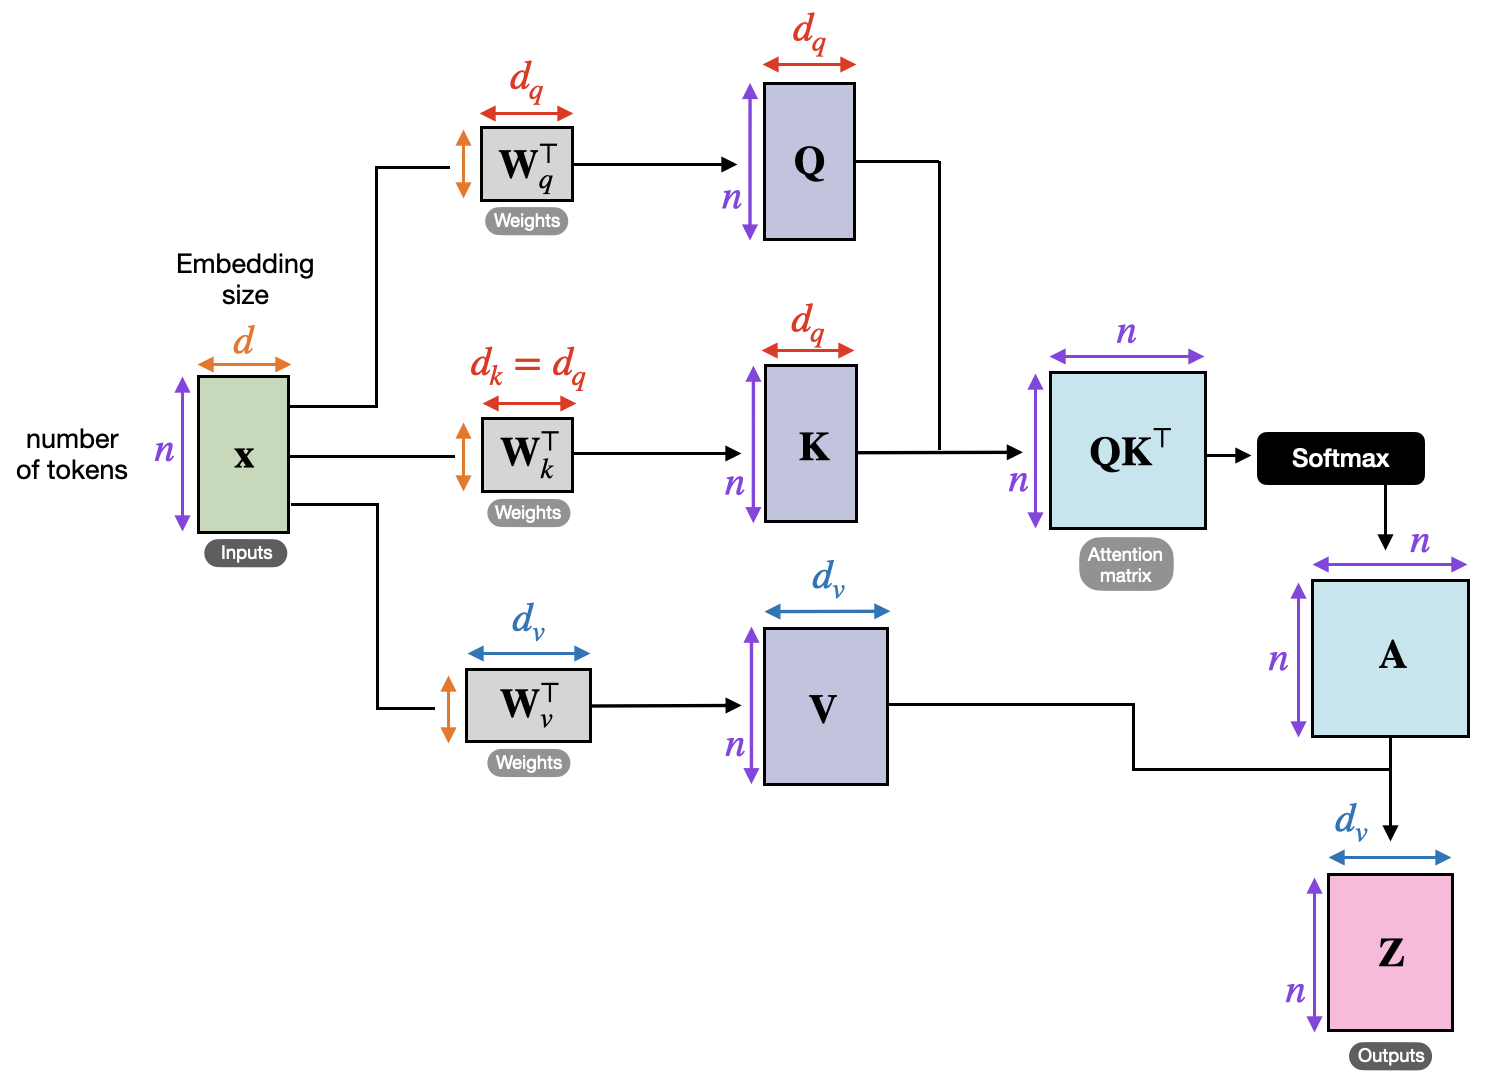

let $d_k = d_q = d_v = D$ to allow layers to stack

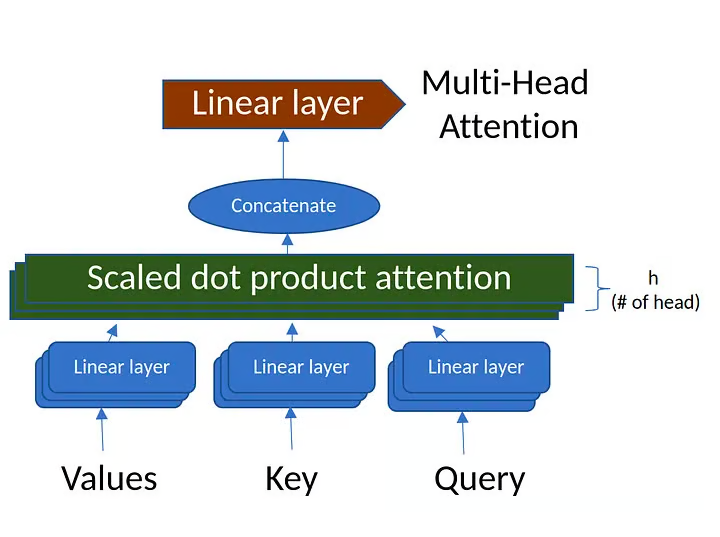

Instead of one head, use h heads with smaller per-head width $d_h=d_{model}/h$. Each head learns different relational subspaces as each head has its own $W_Q, ~ W_K, ~ W_V$ - can capture diverse patterns eg local vs global. Typically choose, $d_{model}=h~x~d_h, ~ d_k=d_v=d_h$. 
Concatenate head outputs and project back to $d_{model}$.

In [25]:
class MultiHeadAttention(nn.Module):
    """
    x: (B, N, D)
        N = num of features
        D = dim of model
    Returns: (B, N, D) where D = out_dim
    """
    def __init__(self,
            dim:int,
            num_heads:int,
            #p_drop: float = 0.0
        ):
        super().__init__()

        self.dim=dim #dim of input
        self.num_heads=num_heads
        
        self.d_k=dim//num_heads #D//h = Dimension of each head's key, query, and value

        self.W_q=nn.Linear(dim,dim) 
        self.W_k=nn.Linear(dim,dim)
        self.W_v=nn.Linear(dim,dim)

        self.W_y=nn.Linear(dim,dim) #output transformation

        # #dropout for attention probabilities - randomly zeroes fraction p and rescales rest by 1/(1-p) (Pytorch inverted dropout)
        # #encourages model not to rely on single sharp attention pattern to improve generalisation
        # self.attn_drop = nn.Dropout(p_drop)

        # #feature dropout on per-token features produced by attention - randomly zeros elements of output vectors
        # self.proj_drop = nn.Dropout(p_drop)

    def split_heads(self,x):
        batch,n,dim=x.size()
        x_split=x.reshape(batch,n,self.num_heads,self.d_k).transpose(-3,-2)
        #print('x ',x.shape)
        #print('x spl', x_split.shape)
        return x_split

    def combine_heads(self,x_split):
        batch,num_heads,n,d_k=x_split.size()
        # x_final = x_split.reshape(batch,n,self.dim).transpose(-2,-1)
        x_final = x_split.reshape(batch,n,self.dim)
        # print(f"x1 shape {x1.shape}")
        # x_final = x1.transpose(-2,-1)
        #print(f"x_final shape {x_final.shape}")
        return x_final

    def scaled_dot_product_attention(self,q_split,k_split,v_split):
        #calculate attention weights
        # k.T flips all dims, including batch -> only need to transpose last two dims
        # k:(B,N,D) -> k.T:(D,N,B)
        # (B,N,D) @ (B,D,N) -> (B,N,N)

        # #single head:
        # scores = (q @ k.transpose(-2, -1)) * self.scale  # (B, N, N)
        # attn = torch.softmax(scores, dim=-1)             # (B, N, N)
        # attn = self.attn_drop(attn)
        # y = attn @ v                                     # (B, N, D)
        # y = self.proj_drop(y)

        k_split_T = k_split.transpose(-2,-1)
        #print('k spl t ',k_split_T.shape)
        #print('q spl ', q_split.shape)  

        attn_scores = torch.matmul(q_split,k_split_T) / math.sqrt(self.d_k)
        attn_probs = torch.softmax(attn_scores,dim=-1)
        y_split = torch.matmul(attn_probs,v_split)
        #print(f"y_split shape {y_split.shape}")

        return y_split

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, N, E)
        q_split = self.split_heads(self.W_q(x))                     # (B, N, D) -> (B, h, N, D/h)
        k_split = self.split_heads(self.W_k(x))                     # (B, N, D) -> (B, h, N, D/h)
        v_split = self.split_heads(self.W_v(x))                     # (B, N, D) -> (B, h, N, D/h)

        y_split=self.scaled_dot_product_attention(q_split,k_split,v_split)
        y=self.W_y(self.combine_heads(y_split))

        return y

In [26]:
class FeedForward(nn.Module):
    def __init__(self,dim,dim_inner):
        #dim = dim of model input and output
        #dim_inner = dim of inner layer in FFNN
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(dim, dim_inner),
            nn.ReLU(),
            nn.Linear(dim_inner, dim)
        )
    def forward(self,x):
        return self.layers(x)

In [27]:
class TransformerLayer(nn.Module):
    """
    Standard transformer block with:
    - Multi-head attention
    - Layer normalization
    - Feed-forward network
    - Residual connections
    """

    def __init__(self,
            embed_dim:int =256,
            num_heads:int=16,
            ffn_dim_multiplier:float=2,
            p_drop: float = 0.2):
        
        super().__init__()

        dim_ff=int(embed_dim*ffn_dim_multiplier)
        self.attn=MultiHeadAttention(dim=embed_dim,num_heads=num_heads)
        self.ff=FeedForward(dim=embed_dim,dim_inner=dim_ff)

        self.norm1=nn.LayerNorm(embed_dim)
        self.norm2=nn.LayerNorm(embed_dim)
        self.dropout=nn.Dropout(p_drop)

    def forward(self,x):
        attn_output=self.attn(x)
        drop=self.dropout(attn_output)

        #add & norm 1
        x=self.norm1(x+drop)

        # feed forward
        ff_output=self.ff(x)
        drop2=self.dropout(ff_output)

        #add & norm 2
        x=self.norm2(x+drop2)

        return x


In [28]:
class MultiLayerTransformerClassifier(nn.Module):
    """
    Multi-layer transformer classifier for point clouds.
    Input: (B, N, 3) point clouds
    Output: (B, num_classes) logits
    """
    def __init__(self,
            num_classes:int,
            embed_dim:int =256,
            num_heads:int=16,
            ffn_dim_multiplier:float=2,
            num_layers:int = 3,
            p_drop: float = 0.2):
        
        super().__init__()

        #embedding layer
        self.embed=nn.Sequential(
            nn.Linear(3,embed_dim),
            nn.ReLU(),
            nn.Dropout(p_drop)
        )

        #stack of transformer layers
        self.transformer_layers=nn.ModuleList([
            TransformerLayer(
                embed_dim=embed_dim,
                num_heads=num_heads,
                ffn_dim_multiplier=ffn_dim_multiplier,
                p_drop=p_drop) for i in range(num_layers)
        ]) 

        #final layer norm
        self.norm = nn.LayerNorm(embed_dim)

        #final linear layer to reduce dim to num of classes for classification
        self.final = nn.Linear(embed_dim, num_classes)

    def forward(self,x):
        #embed point coords
        x=self.embed(x) #(B,N,embed_dim)

        #apply transformer layers
        for layer in self.transformer_layers:
            x=layer(x)

        #final normalisation
        x=self.norm(x)

        #global pooling (mean)
        x=x.mean(dim=1) #(B,embed_dim)

        #classification
        x=self.final(x)

        return x

## test

In [29]:
import pandas as pd
import itertools
import time
import os
from datetime import timedelta
import copy
import seaborn as sns

In [30]:
def plot_multilayer_grid_search_results(results_df):
    """Plot multilayer transformer grid search results from DataFrame"""
    plt.figure(figsize=(18, 15))
    
    # Create subplots - now with 6 plots to include the new parameters
    fig, axs = plt.subplots(3, 2, figsize=(16, 18))
    
    # Plot 1: Embed Dim vs Test Accuracy
    sns.barplot(x='embed_dim', y='test_acc', data=results_df, ax=axs[0, 0], 
                order=sorted(results_df['embed_dim'].unique()))
    axs[0, 0].set_title('Embedding Dimension vs Test Accuracy')
    axs[0, 0].set_xlabel('Embedding Dimension')
    axs[0, 0].set_ylabel('Test Accuracy (%)')
    
    # Plot 2: Num Heads vs Test Accuracy
    sns.barplot(x='num_heads', y='test_acc', data=results_df, ax=axs[0, 1],
                order=sorted(results_df['num_heads'].unique()))
    axs[0, 1].set_title('Number of Attention Heads vs Test Accuracy')
    axs[0, 1].set_xlabel('Number of Attention Heads')
    axs[0, 1].set_ylabel('Test Accuracy (%)')
    
    # Plot 3: Num Layers vs Test Accuracy
    sns.barplot(x='num_layers', y='test_acc', data=results_df, ax=axs[1, 0],
                order=sorted(results_df['num_layers'].unique()))
    axs[1, 0].set_title('Number of Layers vs Test Accuracy')
    axs[1, 0].set_xlabel('Number of Layers')
    axs[1, 0].set_ylabel('Test Accuracy (%)')
    
    # Plot 4: FFN Multiplier vs Test Accuracy
    sns.barplot(x='ffn_multiplier', y='test_acc', data=results_df, ax=axs[1, 1],
                order=sorted(results_df['ffn_multiplier'].unique()))
    axs[1, 1].set_title('FFN Dimension Multiplier vs Test Accuracy')
    axs[1, 1].set_xlabel('FFN Multiplier')
    axs[1, 1].set_ylabel('Test Accuracy (%)')
    
    # Plot 5: Dropout vs Test Accuracy
    sns.barplot(x='p_drop', y='test_acc', data=results_df, ax=axs[2, 0],
                order=sorted(results_df['p_drop'].unique()))
    axs[2, 0].set_title('Dropout Rate vs Test Accuracy')
    axs[2, 0].set_xlabel('Dropout Rate')
    axs[2, 0].set_ylabel('Test Accuracy (%)')
    
    # Plot 6: Top 5 Models
    top5 = results_df.head(5)
    sns.barplot(x='model_name', y='test_acc', data=top5, ax=axs[2, 1])
    axs[2, 1].set_title('Top 5 Models by Test Accuracy')
    axs[2, 1].set_xlabel('Model Configuration')
    axs[2, 1].set_ylabel('Test Accuracy (%)')
    axs[2, 1].set_xticklabels(axs[2, 1].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.savefig('multilayer_grid_search_results.png', dpi=300, bbox_inches='tight')
    plt.show()

In [31]:
def grid_search_transformer_model(
    train_dataloader, 
    test_dataloader, 
    num_classes,
    device,
    embed_dims=[64, 128, 256],
    num_heads_list=[4, 8, 16],
    num_layers_list=[1, 2, 4],
    ffn_multipliers=[2, 4],
    p_drops=[0.0, 0.1, 0.2],
    epochs_list=[20],
    save_best=True,
    results_dir="grid_search_results_multilayer"
):
    """
    Perform grid search for MultiLayerTransformerClassifier with pandas DataFrame tracking.
    Results are sorted by test accuracy.
    """
    
    print("Starting grid search for MultiLayerTransformerClassifier...")
    
    # Create directory for results if it doesn't exist
    if save_best and not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    # Generate all parameter combinations
    param_combinations = list(itertools.product(
        embed_dims, num_heads_list, num_layers_list, ffn_multipliers, p_drops, epochs_list
    ))
    
    # Filter out invalid combinations (embed_dim must be divisible by num_heads)
    valid_combinations = [(ed, nh, nl, ffn, pd, ep) for ed, nh, nl, ffn, pd, ep 
                          in param_combinations if ed % nh == 0]
    
    print(f"Total valid parameter combinations: {len(valid_combinations)}")
    
    # Initialize results DataFrame - using ffn_dim_multiplier to match model parameter name
    
    results_df = pd.DataFrame(columns=[
        'embed_dim', 'num_heads', 'num_layers', 'ffn_multiplier', 'p_drop', 'epochs',
        'train_acc', 'test_acc', 'train_loss', 'test_loss', 
        'time_seconds', 'model_name'
    ])

    
    best_test_acc = 0
    best_model = None
    
    # Loop through combinations
    for i, (embed_dim, num_heads, num_layers, ffn_multiplier, p_drop, epochs) in enumerate(tqdm(valid_combinations, desc="Grid Search Progress")):
        # Create model name
        model_name = f"E{embed_dim}_H{num_heads}_L{num_layers}_F{ffn_multiplier}_D{p_drop}_Ep{epochs}"
        
        print(f"\n[{i+1}/{len(valid_combinations)}] Testing: {model_name}")
        
        # Initialize model
        model = MultiLayerTransformerClassifier(
            num_classes=num_classes,
            embed_dim=embed_dim,
            num_heads=num_heads,
            ffn_dim_multiplier=ffn_multiplier,  # This matches the model parameter
            num_layers=num_layers,
            p_drop=p_drop
        ).to(device)
        
        # Train and time the model
        start_time = time.time()
        train_accs, test_accs, train_losses, test_losses = train_model(model, epochs, verbose=False)
        training_time = time.time() - start_time
        
        # Get final metrics
        final_train_acc = train_accs[-1]
        final_test_acc = test_accs[-1]
        final_train_loss = train_losses[-1]
        final_test_loss = test_losses[-1]
        
        # Add results to DataFrame - using ffn_dim_multiplier for consistency
        
        new_row = pd.DataFrame([{
            'embed_dim': embed_dim,
            'num_heads': num_heads,
            'num_layers': num_layers,
            'ffn_multiplier': ffn_multiplier,
            'p_drop': p_drop,
            'epochs': epochs,
            'train_acc': final_train_acc,
            'test_acc': final_test_acc,
            'train_loss': final_train_loss,
            'test_loss': final_test_loss,
            'time_seconds': training_time,
            'model_name': model_name
        }])

        
        results_df = pd.concat([results_df, new_row], ignore_index=True)
        
        # Save intermediate results
        if save_best:
            results_df.to_csv(f"{results_dir}/grid_search_results.csv", index=False)
        
        # Check if this is the best model
        if final_test_acc > best_test_acc:
            best_test_acc = final_test_acc
            best_model = copy.deepcopy(model)
            
            # Save best model
            if save_best:
                torch.save(model.state_dict(), f"{results_dir}/best_model.pt")
                
        # Print summary
        #print(f"Results: Train Acc: {final_train_acc:.2f}%, Test Acc: {final_test_acc:.2f}%")
        print(f"Time: {timedelta(seconds=int(training_time))}")
        
        # Sort and save updated results
        results_df = results_df.sort_values(by='test_acc', ascending=False).reset_index(drop=True)
        if save_best:
            results_df.to_csv(f"{results_dir}/grid_search_results_sorted.csv", index=False)
    
    # Final summary
    print("\n" + "="*50)
    print("Grid Search Complete!")
    print("="*50)
    
    # Display top 5 models
    print("\nTop 5 Models by Test Accuracy:")
    display(results_df.head(5))
    
    # Visualize results
    plot_multilayer_grid_search_results(results_df)
    
    return results_df, best_model

Starting grid search for MultiLayerTransformerClassifier...
Total valid parameter combinations: 8


Grid Search Progress:   0%|          | 0/8 [00:00<?, ?it/s]


[1/8] Testing: E256_H16_L2_F3_D0.1_Ep20


C:\Users\snevi\AppData\Local\Temp\ipykernel_34672\1677739008.py:95: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)
Grid Search Progress:  12%|█▎        | 1/8 [05:34<39:01, 334.53s/it]

Final: Train Acc: 89.25%, Test Acc: 84.88%
Time: 0:05:34

[2/8] Testing: E256_H16_L2_F3_D0.15_Ep20


Grid Search Progress:  25%|██▌       | 2/8 [11:26<34:27, 344.58s/it]

Final: Train Acc: 88.80%, Test Acc: 84.98%
Time: 0:05:51

[3/8] Testing: E256_H16_L2_F4_D0.1_Ep20


Grid Search Progress:  38%|███▊      | 3/8 [17:53<30:20, 364.09s/it]

Final: Train Acc: 89.52%, Test Acc: 86.92%
Time: 0:06:27

[4/8] Testing: E256_H16_L2_F4_D0.15_Ep20


Grid Search Progress:  50%|█████     | 4/8 [24:16<24:45, 371.41s/it]

Final: Train Acc: 89.13%, Test Acc: 86.38%
Time: 0:06:22

[5/8] Testing: E256_H16_L3_F3_D0.1_Ep20


Grid Search Progress:  62%|██████▎   | 5/8 [32:55<21:14, 424.96s/it]

Final: Train Acc: 88.81%, Test Acc: 79.92%
Time: 0:08:39

[6/8] Testing: E256_H16_L3_F3_D0.15_Ep20


Grid Search Progress:  75%|███████▌  | 6/8 [41:45<15:21, 460.64s/it]

Final: Train Acc: 87.63%, Test Acc: 81.42%
Time: 0:08:49

[7/8] Testing: E256_H16_L3_F4_D0.1_Ep20


Grid Search Progress:  88%|████████▊ | 7/8 [51:23<08:18, 498.78s/it]

Final: Train Acc: 88.91%, Test Acc: 84.99%
Time: 0:09:37

[8/8] Testing: E256_H16_L3_F4_D0.15_Ep20


Grid Search Progress: 100%|██████████| 8/8 [1:01:12<00:00, 459.04s/it]

Final: Train Acc: 88.11%, Test Acc: 83.96%
Time: 0:09:49

Grid Search Complete!

Top 5 Models by Test Accuracy:


,embed_dim,num_heads,num_layers,ffn_multiplier,p_drop,epochs,train_acc,test_acc,train_loss,test_loss,time_seconds,model_name
0,256,16,2,4,0.10,20,89.522315,86.917124,0.312507,0.428499,387.262308,E256_H16_L2_F4_D0.1_Ep20
1,256,16,2,4,0.15,20,89.134414,86.383229,0.330446,0.439393,382.632531,E256_H16_L2_F4_D0.15_Ep20
2,256,16,3,4,0.10,20,88.907775,84.987265,0.342720,0.514850,577.281534,E256_H16_L3_F4_D0.1_Ep20
3,256,16,2,3,0.15,20,88.803173,84.977469,0.352906,0.494929,351.560137,E256_H16_L2_F3_D0.15_Ep20
4,256,16,2,3,0.10,20,89.247734,84.879506,0.343302,0.483519,334.494682,E256_H16_L2_F3_D0.1_Ep20


C:\Users\snevi\AppData\Local\Temp\ipykernel_34672\1622968737.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2, 1].set_xticklabels(axs[2, 1].get_xticklabels(), rotation=45, ha='right')


<Figure size 1800x1500 with 0 Axes>

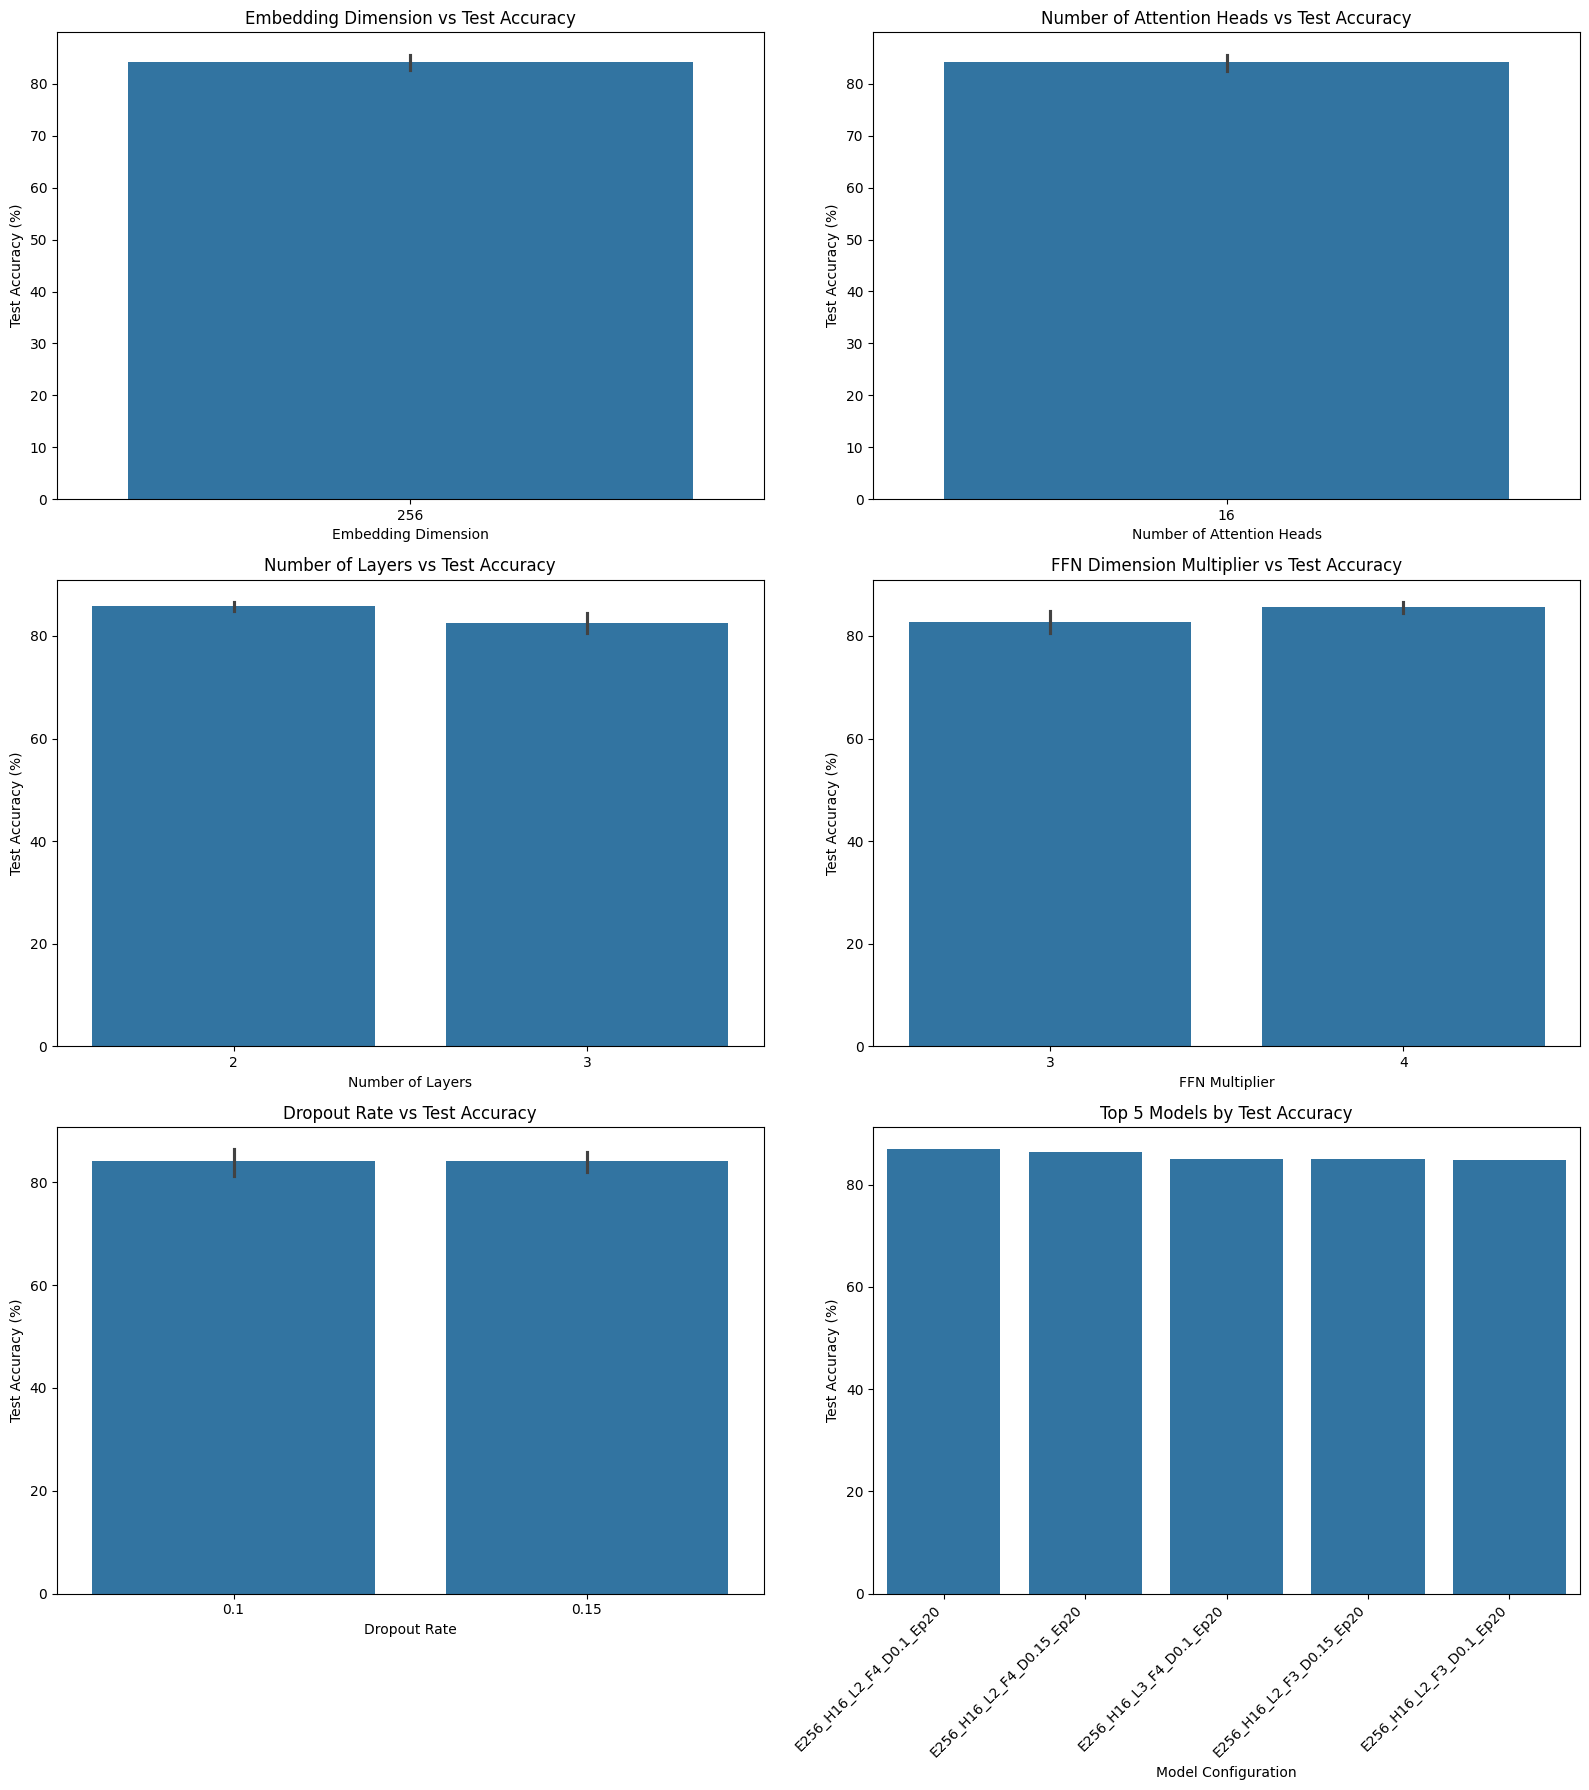

Final: Train Acc: 89.10%, Test Acc: 85.76%


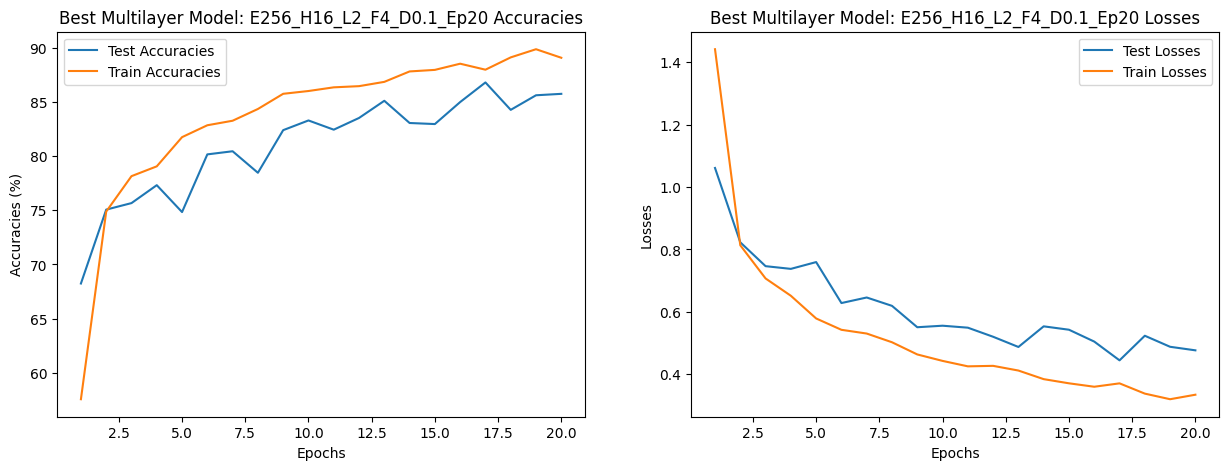

In [32]:
embed_dims = [256]
num_heads_list = [16]
num_layers_list = [2,3]
ffn_multipliers = [3,4]
p_drops = [0.1,0.15]
epochs_list = [20]

# Run grid search for multilayer transformer
results_df, best_model = grid_search_transformer_model(
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    num_classes=NUM_CLASSES,
    device=device,
    embed_dims=embed_dims,
    num_heads_list=num_heads_list,
    num_layers_list=num_layers_list,
    ffn_multipliers=ffn_multipliers,
    p_drops=p_drops,
    epochs_list=epochs_list
)

# Train the best model config for visualization
best_config = results_df.iloc[0]

final_model = MultiLayerTransformerClassifier(
    num_classes=NUM_CLASSES,
    embed_dim=int(best_config['embed_dim']),
    num_heads=int(best_config['num_heads']),
    num_layers=int(best_config['num_layers']),
    ffn_dim_multiplier=int(best_config['ffn_multiplier']), 
    p_drop=float(best_config['p_drop']),
).to(device)



train_accs, test_accs, train_losses, test_losses = train_model(final_model, epochs=int(best_config['epochs']), verbose=False)

# Plot results
plot_acc_losses(
    model_name=f"Best Multilayer Model: {best_config['model_name']}",
    train_accs=train_accs,
    test_accs=test_accs,
    train_losses=train_losses,
    test_losses=test_losses,
    epochs=int(best_config['epochs'])
)